# Model with vaccination strategies

- Previously tested and calibrated model in Basic_Model
- Testing several vaccination strategies: everyone, children, adolescents, adults, elderly
- Calculating the amount of reduced cases for different vaccination rates and strategies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
np.random.seed(123)

In [2]:
@np.vectorize
def beta_step(beta_0,beta_aug,t_start,t_season,t_year,t):
  # beta_0 is the basal beta
  # beta_aug is the beta at high transmission season
  # t_start is start time of the high transmission season
  # t_season is the duration of the high transmission season
  # t_year is the duration of a year (giving the function periodicity)
  # t is current time time
  # normalize time up to a year
  t_norm = t%t_year
  # and now we look for the value of the function
  if(t_norm >= t_start and t_norm <= t_start + t_season):
    value = beta_aug
  else:
    value = beta_0
  return value

In [3]:
def modify_initial_condition(y,prop_imported):
    y_aux = y.copy()
    y_tmp = y.copy()
    y_tmp[:N] = (y_aux[:N]*pop - 1)/pop # suscteptible reduction
    y_tmp[N:2*N] = (y_aux[N:2*N]*pop + 1)/pop # infected grow
    y_tmp[3*N:4*N] = (y_aux[3*N:4*N]*pop + 1)/pop  # increase in new cases per day
    return y_tmp

In [4]:
def n_groups_seasonal_model(y, t, N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec):
    # N is number of age groups 
    S = y[0:N]
    I = y[N:2*N]
    R = y[2*N:3*N]
    C = y[3*N:4*N]
    beta = beta_step(beta_0,beta_aug,t_start,t_season,t_year,t)
    IT = sum(I) #total infected
    S = np.append(S,0)
    I = np.append(I,0)
    R = np.append(R,0)
    S = np.append(0,S)
    I = np.append(0,I)
    R = np.append(0,R)
    C = np.append(C,0)
    C = np.append(0,C)
    l_vec_2 = np.append(0,l_vec)
    l_vec_2 = l_vec_2[:-1]
    dSdt = -beta*S[1:-1]*IT - mu_vec*S[1:-1] - l_vec*S[1:-1] + l_vec_2*S[:-2]
    dIdt =  beta*S[1:-1]*IT - gamma*I[1:-1] - mu_vec*I[1:-1] - l_vec*I[1:-1] + l_vec_2*I[:-2]
    dRdt =  gamma*I[1:-1] - mu_vec*R[1:-1] - l_vec*R[1:-1] + l_vec_2*R[:-2]
    dSdt[0] = dSdt[0] + nu
    dCdt = beta*S[1:-1]*IT
    return np.array([dSdt, dIdt, dRdt,dCdt]).flatten()

In [5]:
def n_groups_seasonal_model_vaccine(y, t, N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec):
    # N is number of age groups 
    S = y[0:N]
    I = y[N:2*N]
    R = y[2*N:3*N]
    C = y[3*N:4*N]
    beta = beta_step(beta_0,beta_aug,t_start,t_season,t_year,t)
    IT = sum(I) #total infected
    S = np.append(S,0)
    I = np.append(I,0)
    R = np.append(R,0)
    S = np.append(0,S)
    I = np.append(0,I)
    R = np.append(0,R)
    C = np.append(C,0)
    C = np.append(0,C)
    l_vec_2 = np.append(0,l_vec)
    l_vec_2 = l_vec_2[:-1]
    dSdt = -beta*S[1:-1]*IT - mu_vec*S[1:-1] - l_vec*S[1:-1] + l_vec_2*S[:-2] - r_vec*S[1:-1]
    dIdt =  beta*S[1:-1]*IT - gamma*I[1:-1] - mu_vec*I[1:-1] - l_vec*I[1:-1] + l_vec_2*I[:-2]
    dRdt =  gamma*I[1:-1] - mu_vec*R[1:-1] - l_vec*R[1:-1] + l_vec_2*R[:-2] + r_vec*S[1:-1]
    dSdt[0] = dSdt[0] + nu
    dCdt = beta*S[1:-1]*IT
    return np.array([dSdt, dIdt, dRdt,dCdt]).flatten()

## Attempt 1: Deterministic Beta 

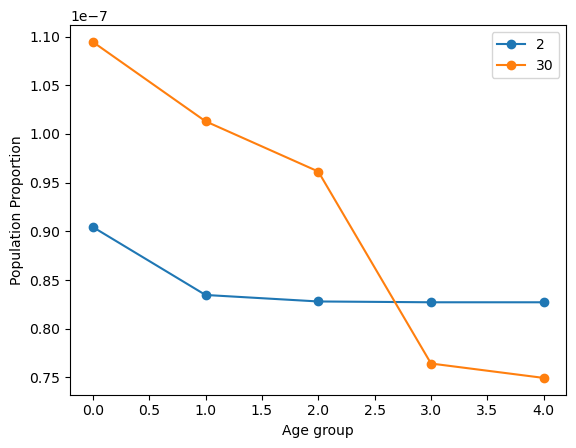

In [6]:
N = 5
pop = 12000000
#y0 = 800000/pop,1600000/pop,900000/pop,8000000/pop,700000/pop,0,0,0,0,0,0,0,0,0,0

alpha1 = 800000/pop
alpha2 = 1600000/pop
alpha3 = 900000/pop
alpha4 = 8000000/pop
alpha5 = 700000/pop

gamma = 1/(7.0)
beta_0 = 0.0*gamma # even like different from 0 it's the same
beta_aug = 2.7*gamma

t_start = 0
t_season = 60
t_year = 365


l1 = 1/(365*5)
nu = alpha1*l1
l2 = l1*alpha1/alpha2
l3 = l2*alpha2/alpha3
l4 = l3*alpha3/alpha4
mu = l4*alpha4/alpha5
l_vec = np.array([l1,l2,l3,l4,0])
mu_vec = np.array([0,0,0,0,mu])


y0 = alpha1,alpha2,alpha3,(8000000-1)/pop,alpha5,0,0,0,1/pop,0,0,0,0,0,0,0,0,0,1/pop,0

t_total = np.linspace(0, 365*1, 10000)

ret = odeint(n_groups_seasonal_model, y0, t_total, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))

seasons = 40
prop_imported = 0.00001
t_total = np.arange(0,365*seasons,1)
t_season_single = np.arange(0,365,1)

for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    inf_total = pop*(ret[1:,15:] - ret[:-1,15:]).sum(axis = 1).sum()
    #print((ret[364,10:]*pop - ret[0,10:]*pop).sum())
    if(season == 2 or season == 30):
        prop_pop = np.array([alpha1,alpha2,alpha3,alpha4,alpha5])*pop*inf_total
        plt.plot((pop/prop_pop)*(ret[1:,15:] - ret[:-1,15:]).sum(axis = 0), '-o', label = season)
        plt.ylabel('Population Proportion')
        plt.xlabel('Age group')
        plt.legend()
        if(season == 2):
            y0_sp = y0
        else:
            y0_rj = y0
plt.show()

### Attempt 1.1: deterministic beta - child vaccination vs elderly vaccination vs overall vaccination

In [7]:
## SP pattern 

N = 5
pop = 12000000
#y0 = 800000/pop,1600000/pop,900000/pop,8000000/pop,700000/pop,0,0,0,0,0,0,0,0,0,0

alpha1 = 800000/pop
alpha2 = 1600000/pop
alpha3 = 900000/pop
alpha4 = 8000000/pop
alpha5 = 700000/pop

gamma = 1/(7.0)
beta_0 = 0.0*gamma # even like different from 0 it's the same
beta_aug = 2.7*gamma

t_start = 0
t_season = 60
t_year = 365


l1 = 1/(365*5)
nu = alpha1*l1
l2 = l1*alpha1/alpha2
l3 = l2*alpha2/alpha3
l4 = l3*alpha3/alpha4
mu = l4*alpha4/alpha5
l_vec = np.array([l1,l2,l3,l4,0])
mu_vec = np.array([0,0,0,0,mu])

inf_time_vacc_1_sp = [] # toddlers and children 
inf_time_vacc_2_sp = [] # adults and adolescents
inf_time_vacc_3_sp = [] # elderly
inf_time_vacc_4_sp = [] # everyone
inf_time_nvacc_sp = [] # no one
r_vec_1 = np.array([100,100,0,0,0])
r_vec_2 = np.array([0,0,100,100,0])
r_vec_3 = np.array([0,0,0,0,200])
r_vec_4 = np.array([40,40,40,40,40])

y0 = alpha1,alpha2,alpha3,(8000000-1)/pop,alpha5,0,0,0,1/pop,0,0,0,0,0,0,0,0,0,1/pop,0
seasons = 40
prop_imported = 0.00001
t_total = np.arange(0,365*seasons,1)
t_season_single = np.arange(0,365,1)

# Children vaccination
for season in np.arange(seasons):
    if(season == 0):
        ret = odeint(n_groups_seasonal_model_vaccine, y0_sp, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_1))
    else:
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_1))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    inf_total = pop*(ret[1:,15:] - ret[:-1,15:]).sum(axis = 1).sum()
    inf_time_vacc_1_sp.append(inf_total)

    
# Adult vaccination
for season in np.arange(seasons):
    if(season == 0):
        ret = odeint(n_groups_seasonal_model_vaccine, y0_sp, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_2))
    else:
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_2))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    inf_total = pop*(ret[1:,15:] - ret[:-1,15:]).sum(axis = 1).sum()
    inf_time_vacc_2_sp.append(inf_total)
    

# Elderly vaccination
for season in np.arange(seasons):
    if(season == 0):
        ret = odeint(n_groups_seasonal_model_vaccine, y0_sp, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_3))
    else:
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_3))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    inf_total = pop*(ret[1:,15:] - ret[:-1,15:]).sum(axis = 1).sum()
    inf_time_vacc_3_sp.append(inf_total)

y0 = alpha1,alpha2,alpha3,(8000000-1)/pop,alpha5,0,0,0,1/pop,0,0,0,0,0,0,0,0,0,1/pop,0
# Everyone vaccination
for season in np.arange(seasons):
    if(season == 0):
        ret = odeint(n_groups_seasonal_model_vaccine, y0_sp, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_4))
    else:
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_4))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    inf_total = pop*(ret[1:,15:] - ret[:-1,15:]).sum(axis = 1).sum()
    inf_time_vacc_4_sp.append(inf_total)
    

# No vaccination
for season in np.arange(seasons):
    if(season == 0):
        ret = odeint(n_groups_seasonal_model, y0_sp, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    else:
        ret = odeint(n_groups_seasonal_model, y0, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    inf_total = pop*(ret[1:,15:] - ret[:-1,15:]).sum(axis = 1).sum()
    inf_time_nvacc_sp.append(inf_total)

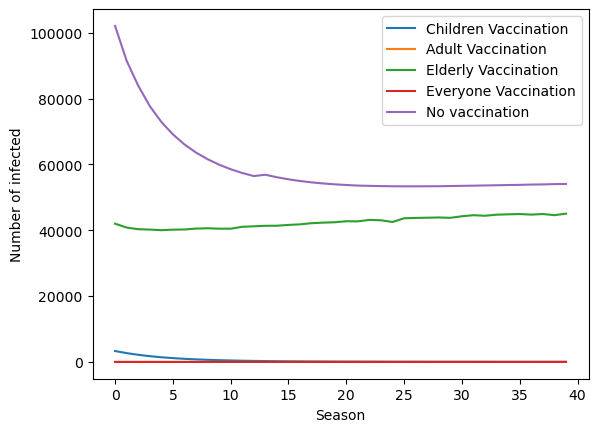

In [8]:
plt.plot(inf_time_vacc_1_sp, label = 'Children Vaccination')
plt.plot(inf_time_vacc_2_sp, label = 'Adult Vaccination')
plt.plot(inf_time_vacc_3_sp, label = 'Elderly Vaccination')
plt.plot(inf_time_vacc_4_sp, label = 'Everyone Vaccination')
plt.plot(inf_time_nvacc_sp, label = 'No vaccination')
plt.xlabel('Season')
plt.ylabel('Number of infected')
plt.legend()
plt.show()

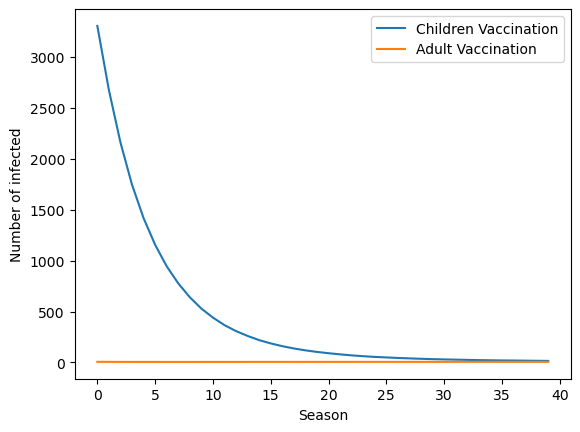

In [9]:
plt.plot(inf_time_vacc_1_sp, label = 'Children Vaccination')
plt.plot(inf_time_vacc_2_sp, label = 'Adult Vaccination')
plt.xlabel('Season')
plt.ylabel('Number of infected')
plt.legend()
plt.show()

In [10]:
## RJ pattern 

N = 5
pop = 12000000
#y0 = 800000/pop,1600000/pop,900000/pop,8000000/pop,700000/pop,0,0,0,0,0,0,0,0,0,0

alpha1 = 800000/pop
alpha2 = 1600000/pop
alpha3 = 900000/pop
alpha4 = 8000000/pop
alpha5 = 700000/pop

gamma = 1/(7.0)
beta_0 = 0.0*gamma # even like different from 0 it's the same
beta_aug = 2.7*gamma

t_start = 0
t_season = 60
t_year = 365


l1 = 1/(365*5)
nu = alpha1*l1
l2 = l1*alpha1/alpha2
l3 = l2*alpha2/alpha3
l4 = l3*alpha3/alpha4
mu = l4*alpha4/alpha5
l_vec = np.array([l1,l2,l3,l4,0])
mu_vec = np.array([0,0,0,0,mu])

inf_time_vacc_1_sp = [] # toddlers and children 
inf_time_vacc_2_sp = [] # adults and adolescents
inf_time_vacc_3_sp = [] # elderly
inf_time_vacc_4_sp = [] # everyone
inf_time_nvacc_sp = [] # no one
r_vec_1 = np.array([100,100,0,0,0])
r_vec_2 = np.array([0,0,100,100,0])
r_vec_3 = np.array([0,0,0,0,200])
r_vec_4 = np.array([40,40,40,40,40])

y0 = alpha1,alpha2,alpha3,(8000000-1)/pop,alpha5,0,0,0,1/pop,0,0,0,0,0,0,0,0,0,1/pop,0
seasons = 40
prop_imported = 0.00001
t_total = np.arange(0,365*seasons,1)
t_season_single = np.arange(0,365,1)

# Children vaccination
for season in np.arange(seasons):
    if(season == 0):
        ret = odeint(n_groups_seasonal_model_vaccine, y0_rj, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_1))
    else:
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_1))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    inf_total = pop*(ret[1:,15:] - ret[:-1,15:]).sum(axis = 1).sum()
    inf_time_vacc_1_sp.append(inf_total)

# Adult vaccination
for season in np.arange(seasons):
    if(season == 0):
        ret = odeint(n_groups_seasonal_model_vaccine, y0_rj, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_2))
    else:
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_2))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    inf_total = pop*(ret[1:,15:] - ret[:-1,15:]).sum(axis = 1).sum()
    inf_time_vacc_2_sp.append(inf_total)
    
    
# Elderly vaccination
for season in np.arange(seasons):
    if(season == 0):
        ret = odeint(n_groups_seasonal_model_vaccine, y0_rj, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_3))
    else:
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_3))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    inf_total = pop*(ret[1:,15:] - ret[:-1,15:]).sum(axis = 1).sum()
    inf_time_vacc_3_sp.append(inf_total)

# Everyone vaccination
for season in np.arange(seasons):
    if(season == 0):
        ret = odeint(n_groups_seasonal_model_vaccine, y0_rj, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_4))
    else:
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec_4))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    inf_total = pop*(ret[1:,15:] - ret[:-1,15:]).sum(axis = 1).sum()
    inf_time_vacc_4_sp.append(inf_total)
    
# No vaccination
for season in np.arange(seasons):
    if(season == 0):
        ret = odeint(n_groups_seasonal_model, y0_rj, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    else:
        ret = odeint(n_groups_seasonal_model, y0, t_season_single, 
                 args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    inf_total = pop*(ret[1:,15:] - ret[:-1,15:]).sum(axis = 1).sum()
    inf_time_nvacc_sp.append(inf_total)

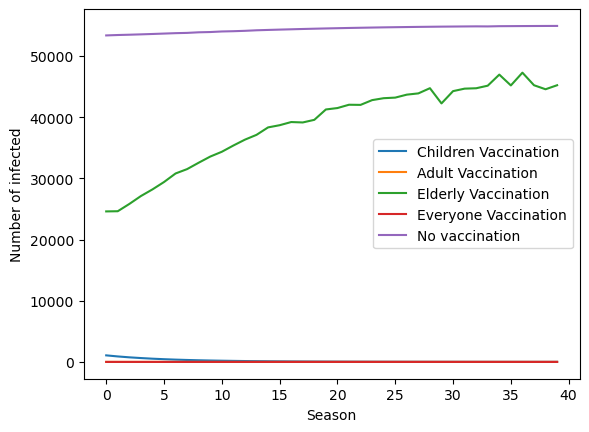

In [11]:
plt.plot(inf_time_vacc_1_sp, label = 'Children Vaccination')
plt.plot(inf_time_vacc_2_sp, label = 'Adult Vaccination')
plt.plot(inf_time_vacc_3_sp, label = 'Elderly Vaccination')
plt.plot(inf_time_vacc_4_sp, label = 'Everyone Vaccination')
plt.plot(inf_time_nvacc_sp, label = 'No vaccination')
plt.xlabel('Season')
plt.ylabel('Number of infected')
plt.legend()
plt.show()

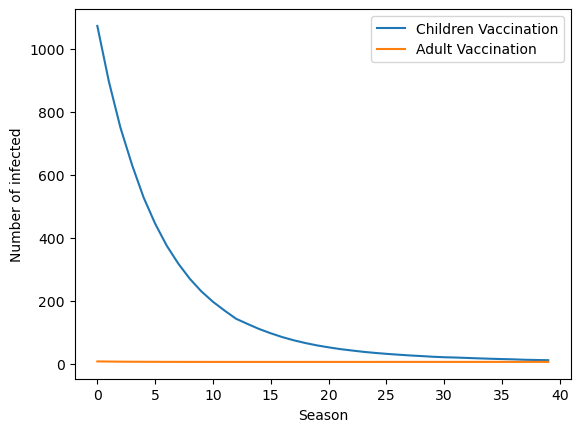

In [12]:
plt.plot(inf_time_vacc_1_sp, label = 'Children Vaccination')
plt.plot(inf_time_vacc_2_sp, label = 'Adult Vaccination')
plt.xlabel('Season')
plt.ylabel('Number of infected')
plt.legend()
plt.show()

# Checking the model

In [13]:
def modify_initial_condition_2(y0, prop_imported):
    y0_aux = y0.copy()
    y0[3] = (y0_aux[3]*pop - 1)/pop # suscteptible reduction
    y0[8] = (y0_aux[8]*pop + 1)/pop # infected grow
    y0[18] = (y0_aux[18]*pop + 1)/pop  # increase in new cases per day
    return y0

2.6
0.0
0.06666666666666667 0.06666666666666667


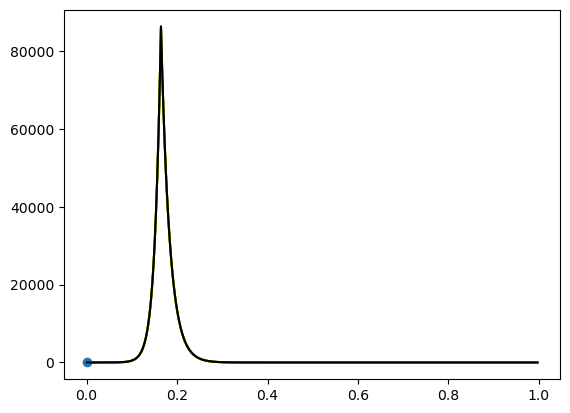

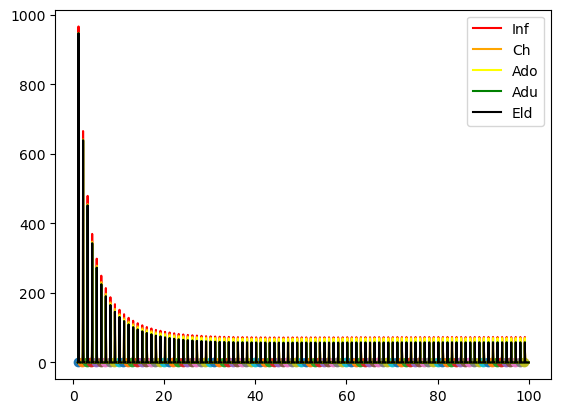

In [14]:
N = 5
pop = 12000000
#y0 = 800000/pop,1600000/pop,900000/pop,8000000/pop,700000/pop,0,0,0,0,0,0,0,0,0,0

alpha1 = 800000/pop
alpha2 = 1600000/pop
alpha3 = 900000/pop
alpha4 = 8000000/pop
alpha5 = 700000/pop

gamma = 1/(7.0)
beta_0 = 0.0*gamma # even like different from 0 it's the same
beta_aug = 2.6*gamma
print(beta_aug/gamma)
print(beta_0/gamma)
t_start = 0
t_season = 60
t_year = 365


l1 = 1/(365*5)
nu = alpha1*l1
l2 = l1*alpha1/alpha2
l3 = l2*alpha2/alpha3
l4 = l3*alpha3/alpha4
mu = l4*alpha4/alpha5

print(nu/l1,alpha1)

l_vec = np.array([l1,l2,l3,l4,0])
mu_vec = np.array([0,0,0,0,mu])


t_total = np.linspace(0, 365*1, 10000)

y0 = alpha1,alpha2,alpha3,(8000000-1)/pop,alpha5,0,0,0,1/pop,0,0,0,0,0,0,0,0,0,1/pop,0

prop_imported = 0
ret = odeint(n_groups_seasonal_model, y0, t_total, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))

seasons = 100
t_total = np.arange(0,365*seasons,1)
t_season_single = np.arange(0,365,1)

for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition_2(y0,prop_imported)
    inf_total = pop*(ret[1:,15:] - ret[:-1,15:]).sum(axis = 1).sum()
    plt.plot((t_season_single+season*365)/365,ret[:,N]/alpha1*inf_total, label = 'Inf', color = 'red')
    plt.plot((t_season_single+season*365)/365,ret[:,N+1]/alpha2*inf_total, label = 'Ch', color = 'orange')
    plt.plot((t_season_single+season*365)/365,ret[:,N+2]/alpha3*inf_total, label = 'Ado', color = 'yellow')
    plt.plot((t_season_single+season*365)/365,ret[:,N+3]/alpha4*inf_total, label = 'Adu', color = 'green')
    plt.plot((t_season_single+season*365)/365,ret[:,N+4]/alpha5*inf_total, label = 'Eld', color = 'black')
    plt.scatter((season*365)/365,y0[N:2*N].sum())
    if(season == 0):
        plt.show()
    if(season == 1):
        plt.legend()

plt.show()

2.7
0.0
0.06666666666666667 0.06666666666666667


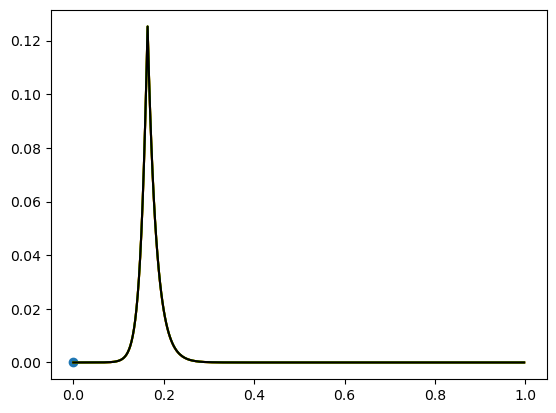

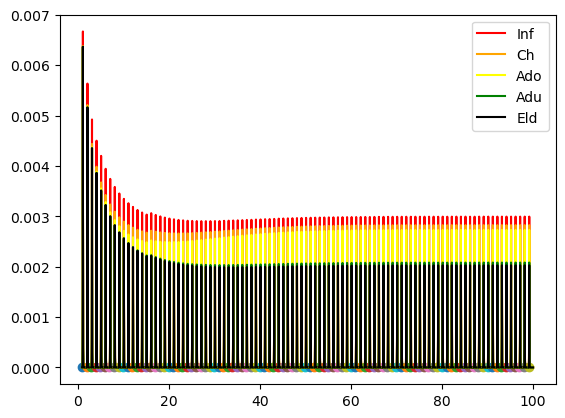

In [15]:
N = 5
pop = 12000000
#y0 = 800000/pop,1600000/pop,900000/pop,8000000/pop,700000/pop,0,0,0,0,0,0,0,0,0,0

alpha1 = 800000/pop
alpha2 = 1600000/pop
alpha3 = 900000/pop
alpha4 = 8000000/pop
alpha5 = 700000/pop

gamma = 1/(7.0)
beta_0 = 0.0*gamma # even like different from 0 it's the same
beta_aug = 2.7*gamma
print(beta_aug/gamma)
print(beta_0/gamma)
t_start = 0
t_season = 60
t_year = 365


l1 = 1/(365*5)
nu = alpha1*l1
l2 = l1*alpha1/alpha2
l3 = l2*alpha2/alpha3
l4 = l3*alpha3/alpha4
mu = l4*alpha4/alpha5

print(nu/l1,alpha1)

l_vec = np.array([l1,l2,l3,l4,0])
mu_vec = np.array([0,0,0,0,mu])


t_total = np.linspace(0, 365*1, 10000)

y0 = alpha1,alpha2,alpha3,(8000000-1)/pop,alpha5,0,0,0,1/pop,0,0,0,0,0,0,0,0,0,1/pop,0

prop_imported = 0
ret = odeint(n_groups_seasonal_model, y0, t_total, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))

seasons = 100
t_total = np.arange(0,365*seasons,1)
t_season_single = np.arange(0,365,1)

for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    inf_total = pop*(ret[1:,15:] - ret[:-1,15:]).sum(axis = 1).sum()
    plt.plot((t_season_single+season*365)/365,ret[:,N]/alpha1, label = 'Inf', color = 'red')
    plt.plot((t_season_single+season*365)/365,ret[:,N+1]/alpha2, label = 'Ch', color = 'orange')
    plt.plot((t_season_single+season*365)/365,ret[:,N+2]/alpha3, label = 'Ado', color = 'yellow')
    plt.plot((t_season_single+season*365)/365,ret[:,N+3]/alpha4, label = 'Adu', color = 'green')
    plt.plot((t_season_single+season*365)/365,ret[:,N+4]/alpha5, label = 'Eld', color = 'black')
    plt.scatter((season*365)/365,y0[N:2*N].sum())
    if(season == 0):
        plt.show()
    if(season == 1):
        plt.legend()

plt.show()